In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('/Users/dodkins/PythonProjects/stocks/options_testing/options_testing')
from datetime import datetime 
import pandas as pd
import opstrat as op

from robinhood import get_options_plays
from yahoo import get_tsla 
from plots import plot_candles, plot_timeseries, plot_line
from options import get_option_history
from utils import aggregate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = '/Users/dodkins/PythonProjects/stocks/options_testing/data/'

In [3]:
tsla = pd.DataFrame(columns=['date', 'open','close'])
for col, dtype in zip(['date', 'open','close'], [str, float, float]):
    tsla_col_loc = os.path.join(data_dir, f'tsla_minutely_{col}.txt')
    tsla[col] = np.loadtxt(tsla_col_loc, delimiter=',', dtype=dtype)

In [4]:
tsla

date        open       close
0       2022-04-22 14:01:00  334.219967  334.333300
1       2022-04-22 14:02:00  334.413300  334.529967
2       2022-04-22 14:03:00  334.503300  334.283300
3       2022-04-22 14:04:00  334.253300  334.799967
4       2022-04-22 14:05:00  334.799967  335.056633
...                     ...         ...         ...
35995   2022-09-02 15:56:00  270.390000  269.910000
35996   2022-09-02 15:57:00  269.900000  269.410000
35997   2022-09-02 15:58:00  269.410000  269.810000
35998   2022-09-02 15:59:00  269.820000  269.800000
35999   2022-09-02 16:00:00  269.770000  270.210000

[36000 rows x 3 columns]

In [17]:
tsla = tsla.set_index('date')

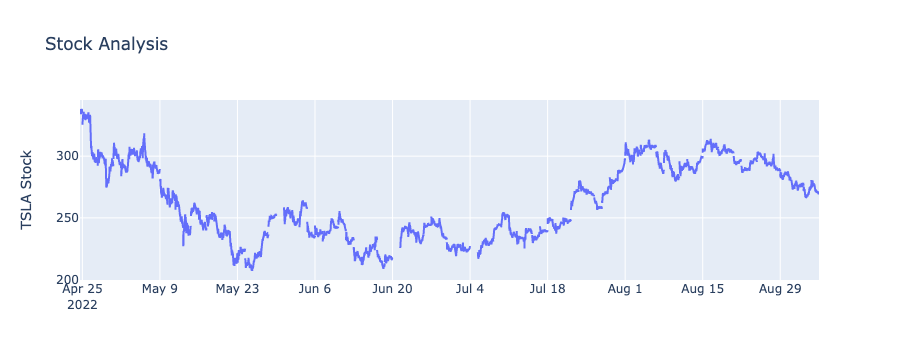

In [18]:
plot_timeseries(tsla)

In [19]:
tsla

open       close
date                                        
2022-04-22 14:01:00   334.219967  334.333300
 2022-04-22 14:02:00  334.413300  334.529967
 2022-04-22 14:03:00  334.503300  334.283300
 2022-04-22 14:04:00  334.253300  334.799967
 2022-04-22 14:05:00  334.799967  335.056633
...                          ...         ...
 2022-09-02 15:56:00  270.390000  269.910000
 2022-09-02 15:57:00  269.900000  269.410000
 2022-09-02 15:58:00  269.410000  269.810000
 2022-09-02 15:59:00  269.820000  269.800000
 2022-09-02 16:00:00  269.770000  270.210000

[36000 rows x 2 columns]

In [21]:
tsla_hourly = aggregate(tsla, freq='hourly')

In [22]:
tsla

open       close
date                                        
2022-04-22 14:01:00   334.219967  334.333300
 2022-04-22 14:02:00  334.413300  334.529967
 2022-04-22 14:03:00  334.503300  334.283300
 2022-04-22 14:04:00  334.253300  334.799967
 2022-04-22 14:05:00  334.799967  335.056633
...                          ...         ...
 2022-09-02 15:56:00  270.390000  269.910000
 2022-09-02 15:57:00  269.900000  269.410000
 2022-09-02 15:58:00  269.410000  269.810000
 2022-09-02 15:59:00  269.820000  269.800000
 2022-09-02 16:00:00  269.770000  270.210000

[36000 rows x 2 columns]

In [23]:
option_history = get_option_history(tsla_hourly, strike=285, expiration='9/30/2022', risk_free=3)

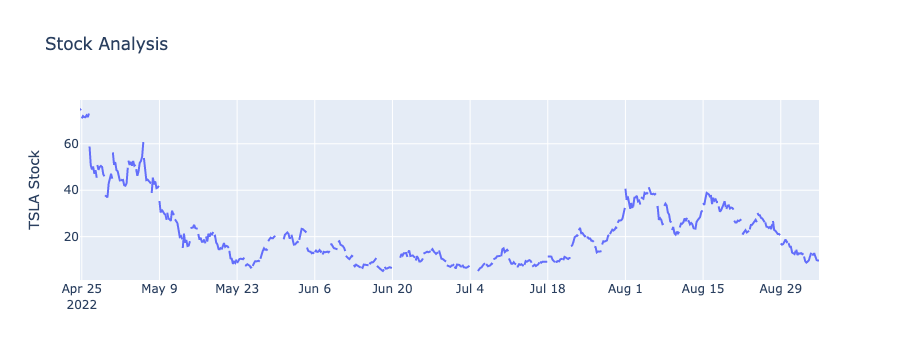

In [27]:
plot_line(option_history)

In [34]:
leap_hourly = get_option_history(aggregate(tsla, freq='hourly'), strike=285, expiration='9/30/2022', risk_free=3)

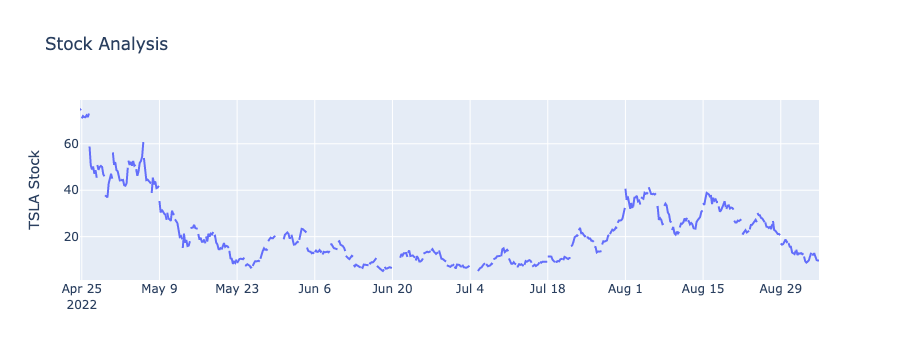

In [35]:
plot_line(leap_hourly)

In [34]:
short_call = tsla_hourly['close']*1.05

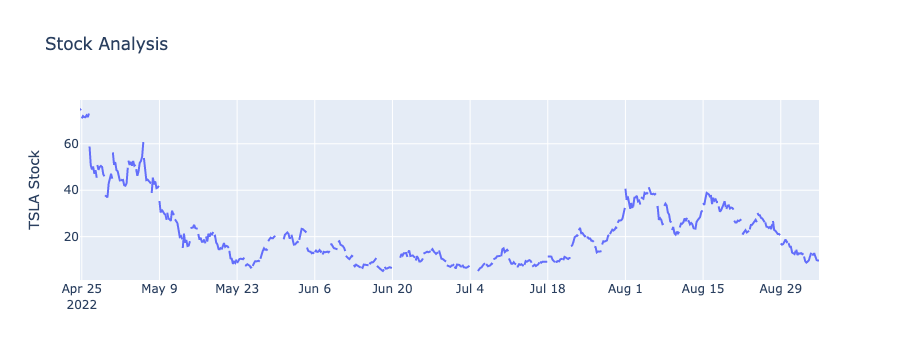

In [181]:
plot_line(leap_hourly)

In [61]:
def get_weekly_short_call(df_minutely, percent_offset=5):
    short_call = aggregate(df_minutely, freq='weekly')
    short_call = short_call.rename(columns={'open': 'underlying open', 'high': 'underlying high', 'low': 'underlying low', 'close': 'underlying close'})
    short_call['strike'] = short_call['underlying open']*(1+percent_offset/100.)
    short_call['call open'] = np.nan
    short_call['call close'] = np.nan
    short_call['profit'] = np.nan
    short_call['date'] = short_call.index
    short_call=short_call.reset_index(drop=True)
    for iw, (date, week) in enumerate(short_call.iterrows()):
        bsm_open = op.black_scholes(K=week['strike'], St=week['underlying open'], r=3, t=5, v=53, type='c')
        bsm_close = op.black_scholes(K=week['strike'], St=week['underlying close'], r=3, t=0, v=53, type='c')
        short_call.at[iw, 'call open'] = bsm_open['value']['option value']
        short_call.at[iw, 'call close'] = bsm_close['value']['option value']
    short_call['profit'] = short_call['call open'] - short_call['call close']
    short_call['running profit'] = short_call['profit'].cumsum()
    return short_call

In [51]:
short_call = get_weekly_short_call(tsla_hourly)

In [52]:
short_call['profit'].array.sum()

-34.78209620520772

In [56]:
tsla_weekly = aggregate(tsla, 'weekly')

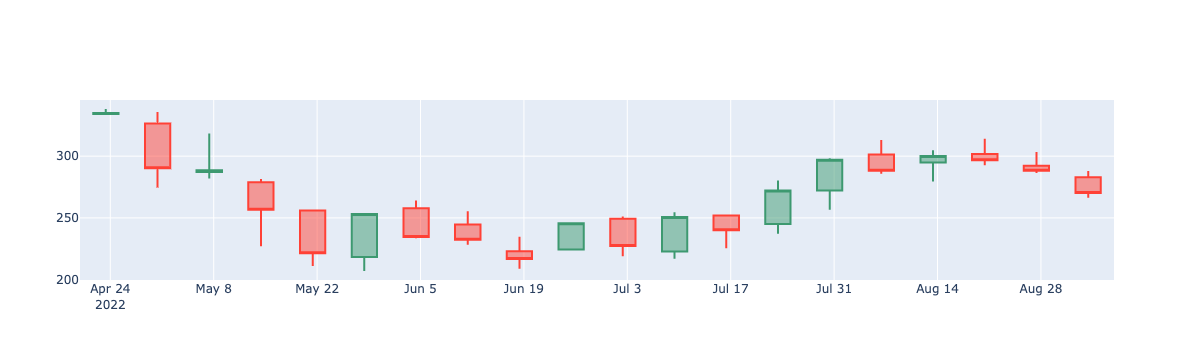

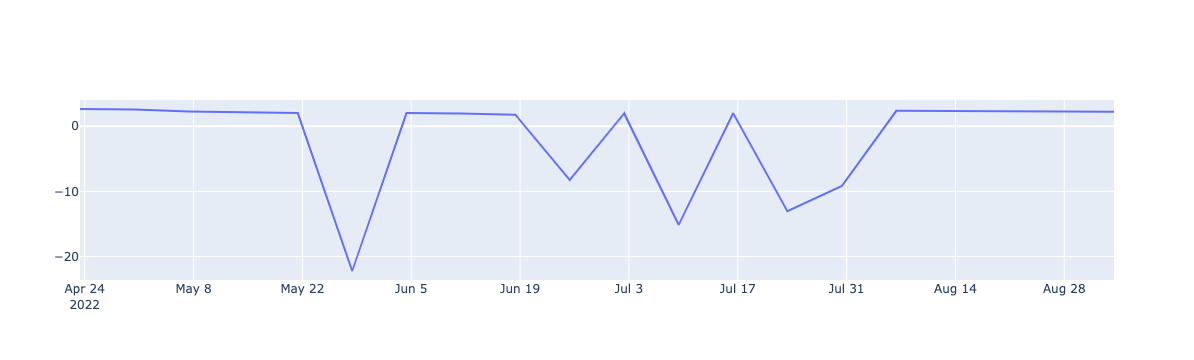

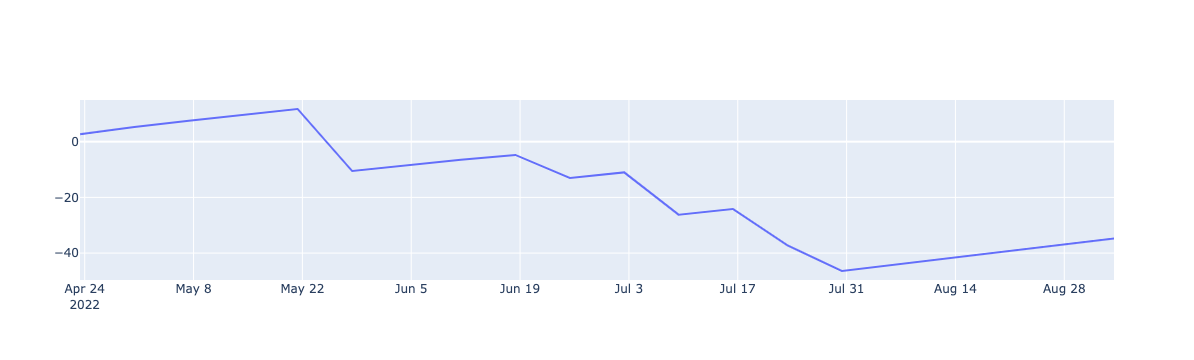

In [62]:
plot_candles(tsla_weekly, show_afterhours=True)
plot_line(short_call, value='profit', show_afterhours=True)
plot_line(short_call, value='running profit', show_afterhours=True)

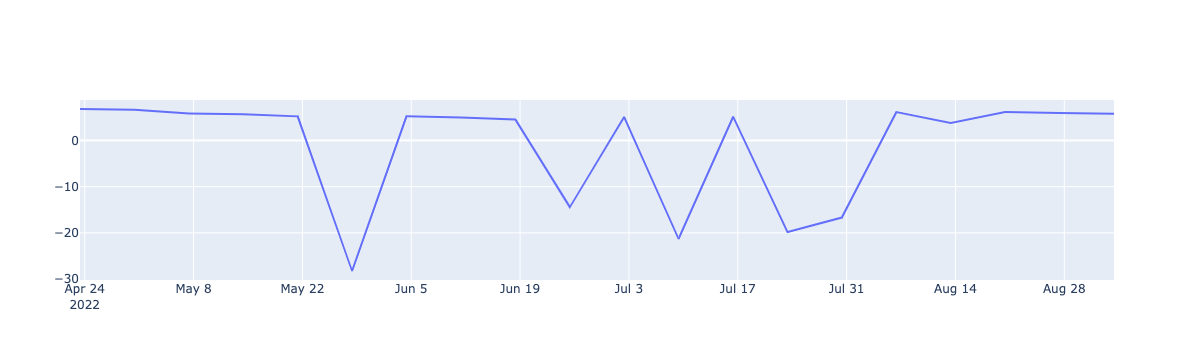

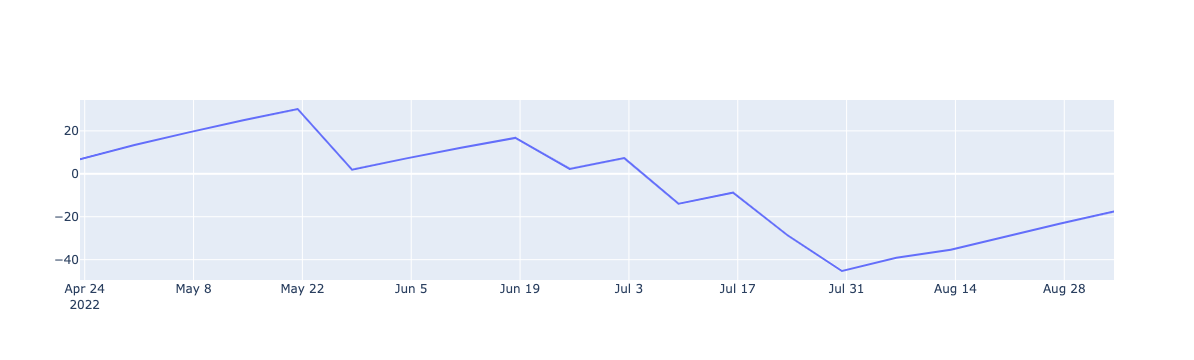

In [64]:
short_call = get_weekly_short_call(tsla_hourly, 1)
plot_line(short_call, value='profit', show_afterhours=True)
plot_line(short_call, value='running profit', show_afterhours=True)

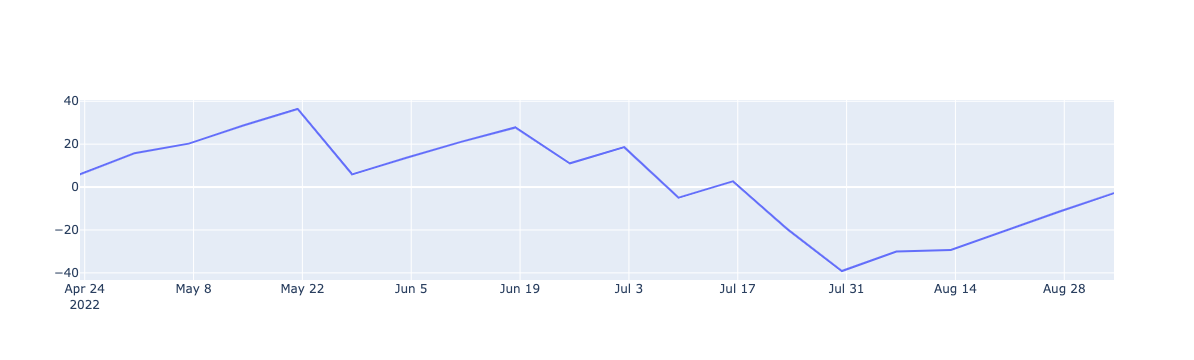

In [66]:
short_call = get_weekly_short_call(tsla_hourly, -1)
# plot_line(short_call, value='profit', show_afterhours=True)
plot_line(short_call, value='running profit', show_afterhours=True)

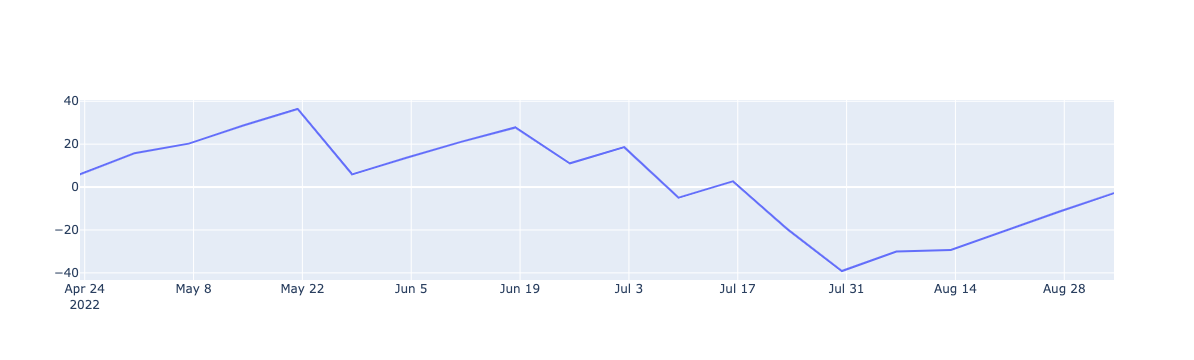

In [67]:
short_call = get_weekly_short_call(tsla_hourly, -1)
plot_line(short_call, value='running profit', show_afterhours=True)

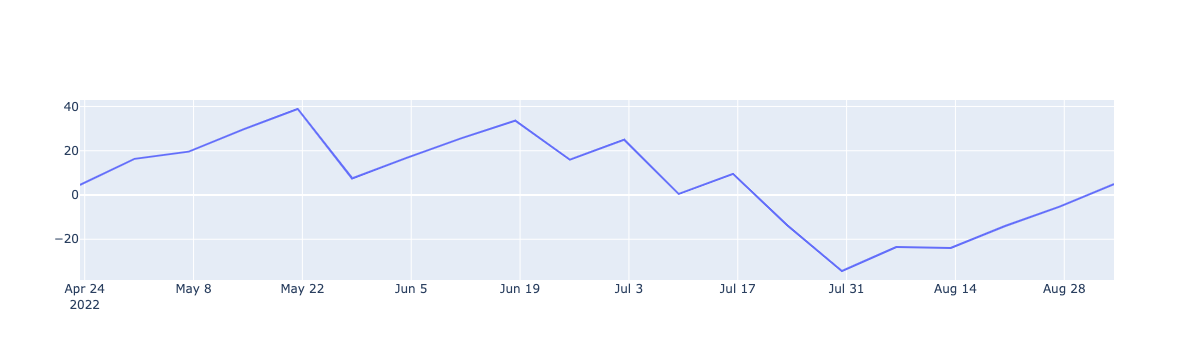

In [68]:
short_call = get_weekly_short_call(tsla_hourly, -2)
plot_line(short_call, value='running profit', show_afterhours=True)

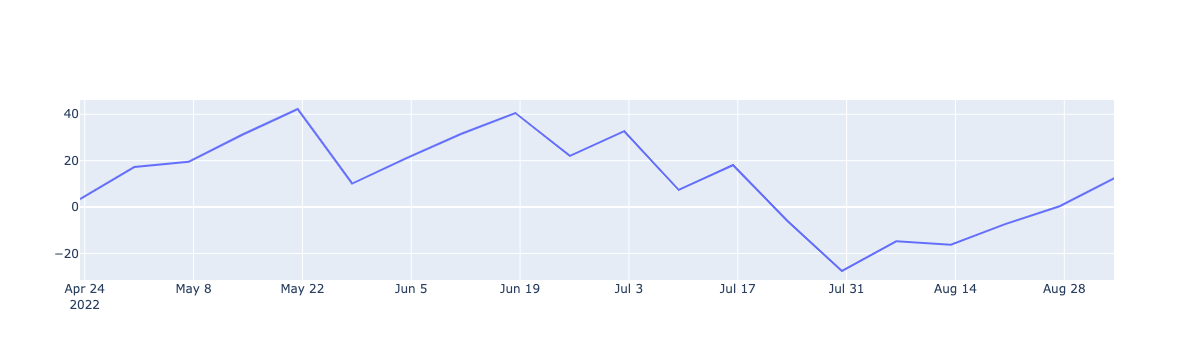

In [69]:
short_call = get_weekly_short_call(tsla_hourly, -3)
plot_line(short_call, value='running profit', show_afterhours=True)

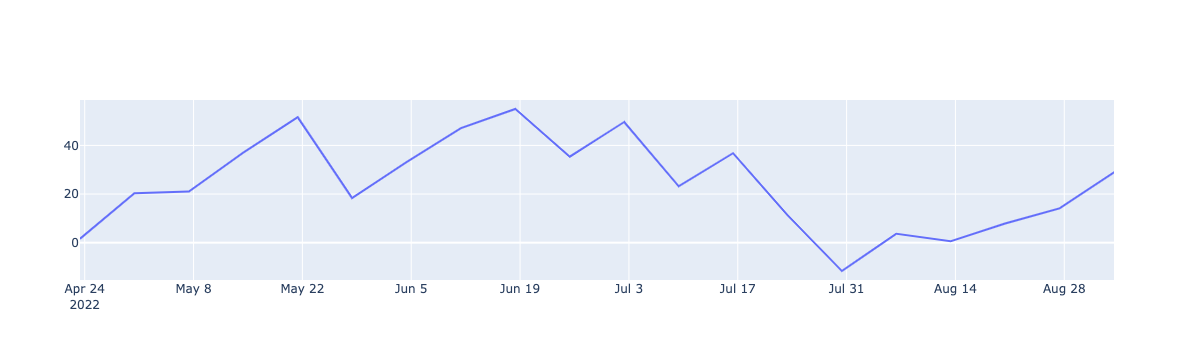

In [71]:
short_call = get_weekly_short_call(tsla_hourly, -5)
plot_line(short_call, value='running profit', show_afterhours=True)

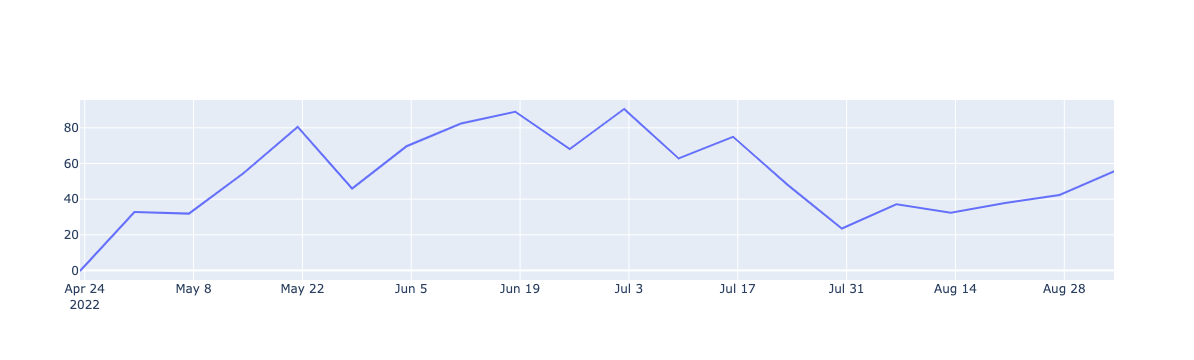

In [72]:
short_call = get_weekly_short_call(tsla_hourly, -10)
plot_line(short_call, value='running profit', show_afterhours=True)

In [73]:
short_call

underlying open  underlying high  underlying low  underlying close  \
0        334.219967       335.076633      334.219967        335.016633   
1        326.463301       332.996633      278.726639        290.253304   
2        287.209971       317.693302      283.753305        288.549971   
3        278.803305       278.803305      233.699977        256.529974   
4        255.999974       255.999974      213.896645        221.299978   
5        218.333312       252.729975      207.999979        253.209975   
6        257.869974       261.563307      234.449977        234.516643   
7        244.666642       251.343308      229.249977        232.229977   
8        222.999978       232.759977      209.683312        216.759978   
9        224.459978       245.419975      224.459978        245.706642   
10       249.369975       249.369975      221.043311        227.263311   
11       222.709978       254.209975      218.173312        250.763308   
12       251.853308       251.853308      225.613311        240.066643   
13       244.999976       279.186639      240.563309        272.243306   
14       272.206639       296.739970      257.333308        297.149970   
15       301.333303       311.999969      287.543305        288.169971   
16       294.833304       302.956636      280.919972        300.029970   
17       301.773303       311.963302      294.444971        296.666637   
18       292.136637       302.746636      287.546638        288.090000   
19       283.000000       288.000000      266.700000        270.210000   

        strike  call open  call close     profit                date  \
0   300.797970  33.900615   34.218663  -0.318048 2022-04-23 09:30:00   
1   293.816971  33.113841    0.000000  33.113841 2022-04-30 09:30:00   
2   258.488974  29.132295   30.060997  -0.928702 2022-05-07 09:30:00   
3   250.922975  28.279590    5.606999  22.672591 2022-05-14 09:30:00   
4   230.399977  25.966602    0.000000  25.966602 2022-05-21 09:30:00   
5   196.499980  22.145995   56.709994 -34.564000 2022-05-28 09:30:00   
6   232.082977  26.156279    2.433666  23.722613 2022-06-04 09:30:00   
7   220.199978  24.817038   12.029999  12.787040 2022-06-11 09:30:00   
8   200.699980  22.619344   16.059998   6.559346 2022-06-18 09:30:00   
9   202.013980  22.767435   43.692662 -20.925227 2022-06-25 09:30:00   
10  224.432978  25.294107    2.830333  22.463774 2022-07-02 09:30:00   
11  200.438980  22.589929   50.324328 -27.734399 2022-07-09 09:30:00   
12  226.667977  25.545997   13.398665  12.147331 2022-07-16 09:30:00   
13  220.499978  24.850849   51.743328 -26.892479 2022-07-23 09:30:00   
14  244.985976  27.610477   52.163995 -24.553518 2022-07-30 09:30:00   
15  271.199973  30.564854   16.969998  13.594856 2022-08-06 09:30:00   
16  265.349973  29.905546   34.679997  -4.774451 2022-08-13 09:30:00   
17  271.595973  30.609484   25.070664   5.538820 2022-08-20 09:30:00   
18  262.922974  29.632017   25.167026   4.464991 2022-08-27 09:30:00   
19  254.700000  28.705269   15.510000  13.195269 2022-09-03 09:30:00   

    running profit  
0        -0.318048  
1        32.795793  
2        31.867092  
3        54.539682  
4        80.506284  
5        45.942284  
6        69.664897  
7        82.451937  
8        89.011283  
9        68.086056  
10       90.549830  
11       62.815430  
12       74.962762  
13       48.070283  
14       23.516765  
15       37.111620  
16       32.337169  
17       37.875989  
18       42.340980  
19       55.536250

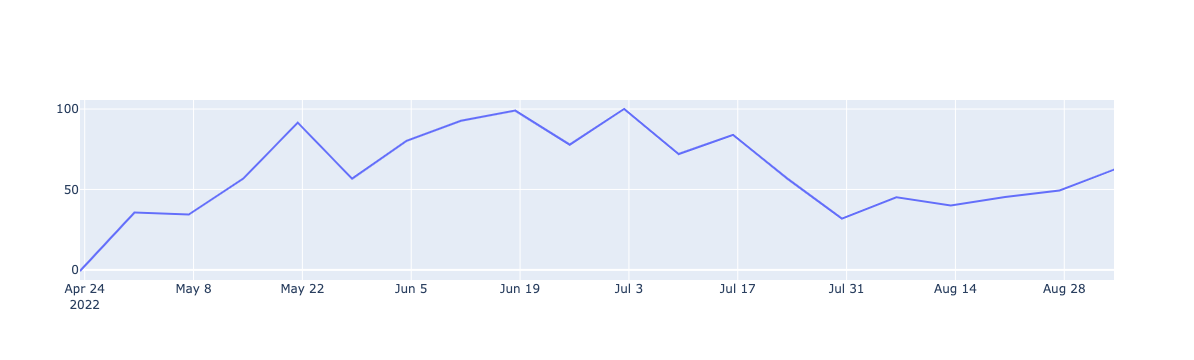

In [74]:
short_call = get_weekly_short_call(tsla_hourly, -20)
plot_line(short_call, value='running profit', show_afterhours=True)

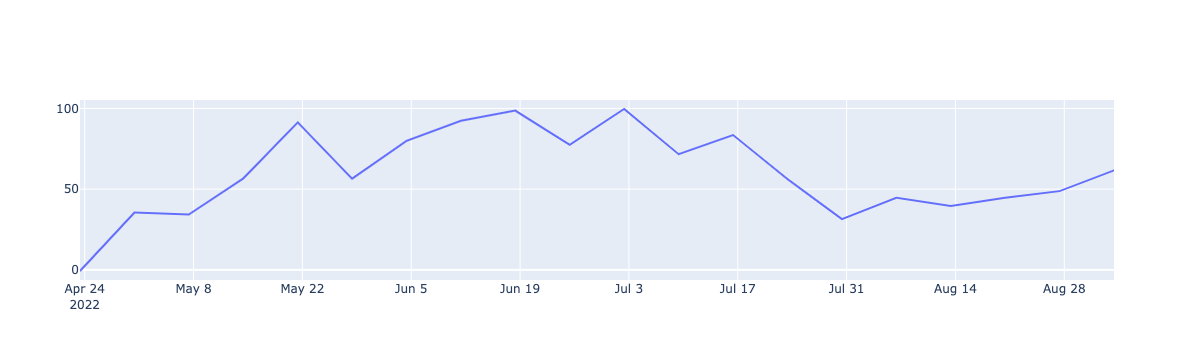

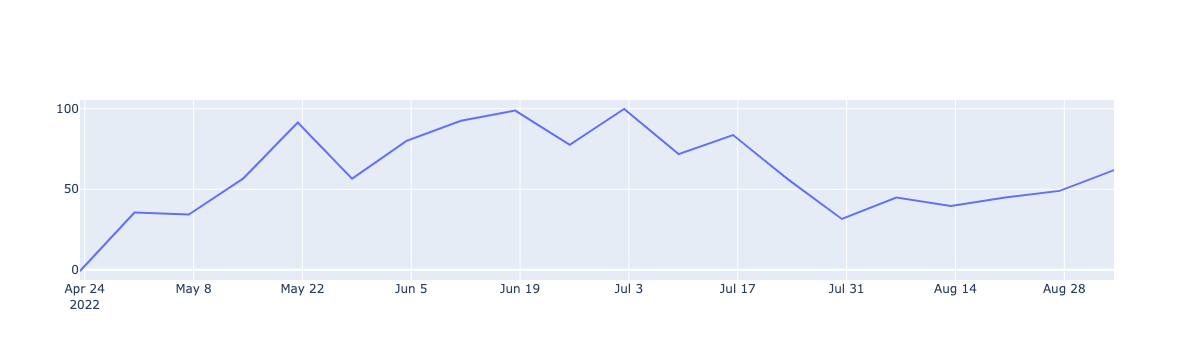

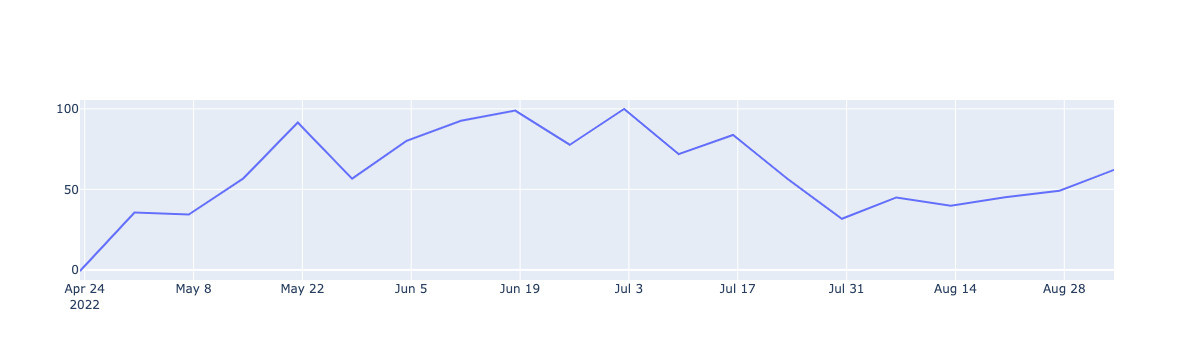

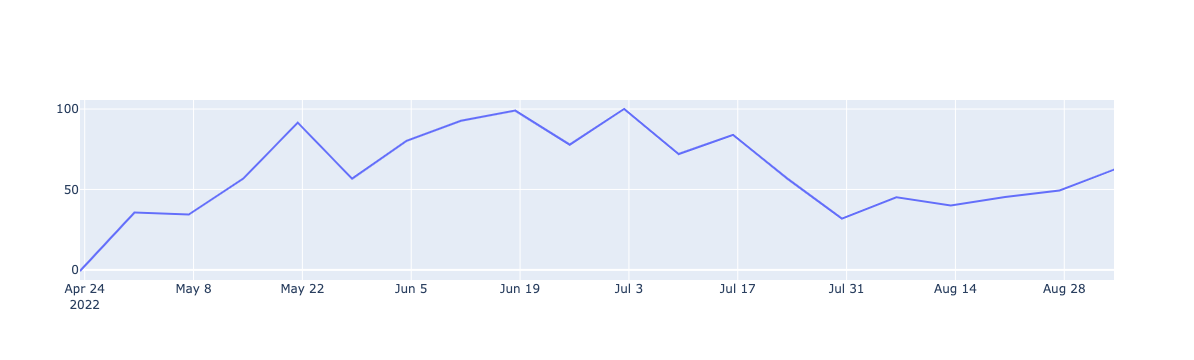

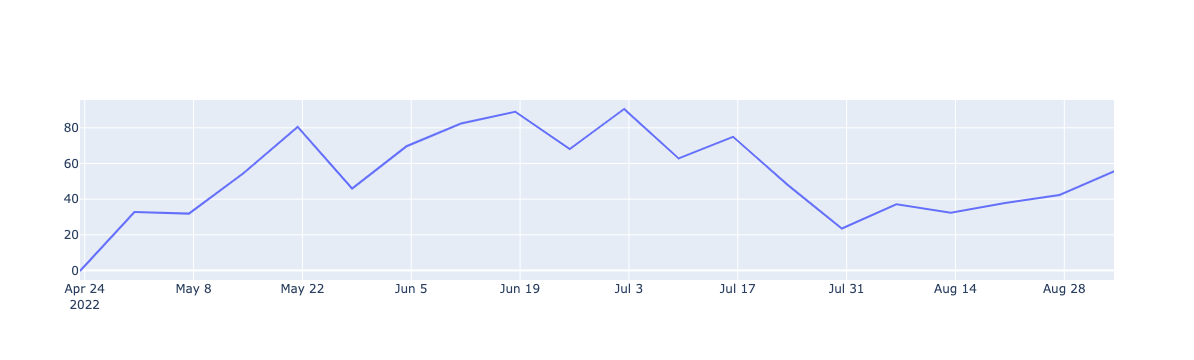

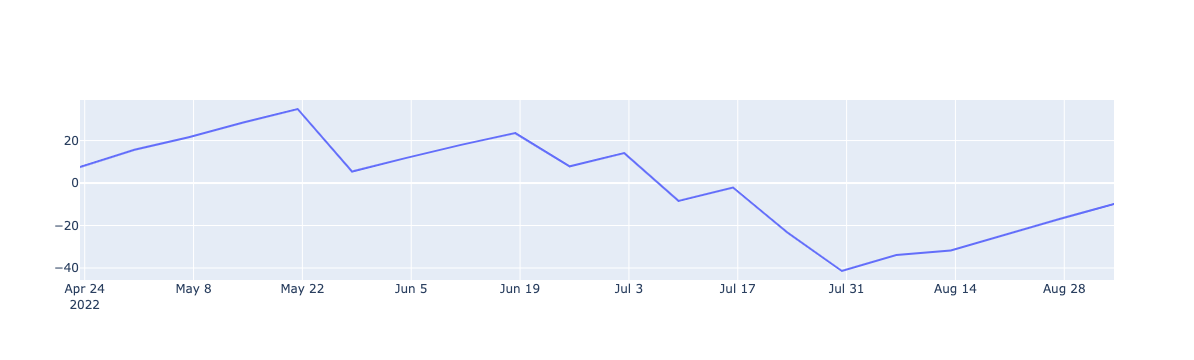

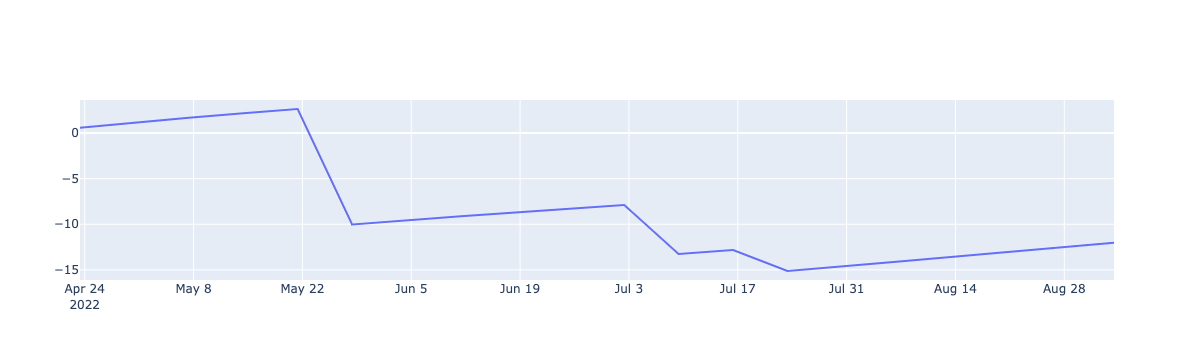

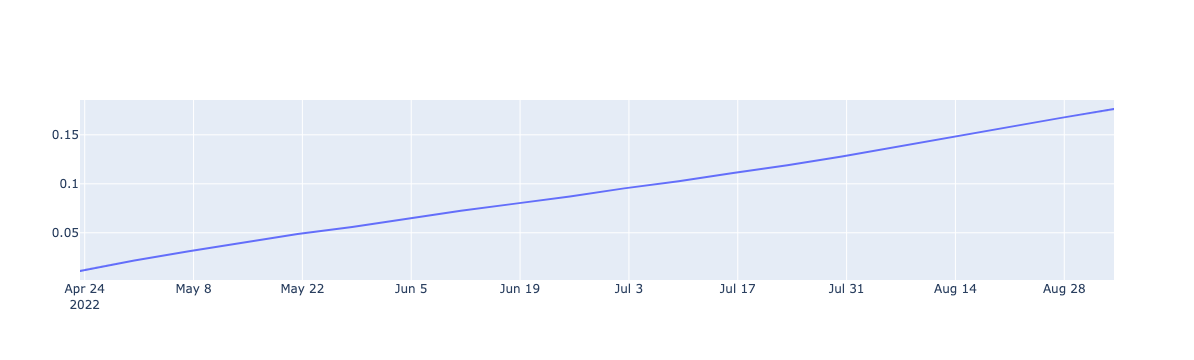

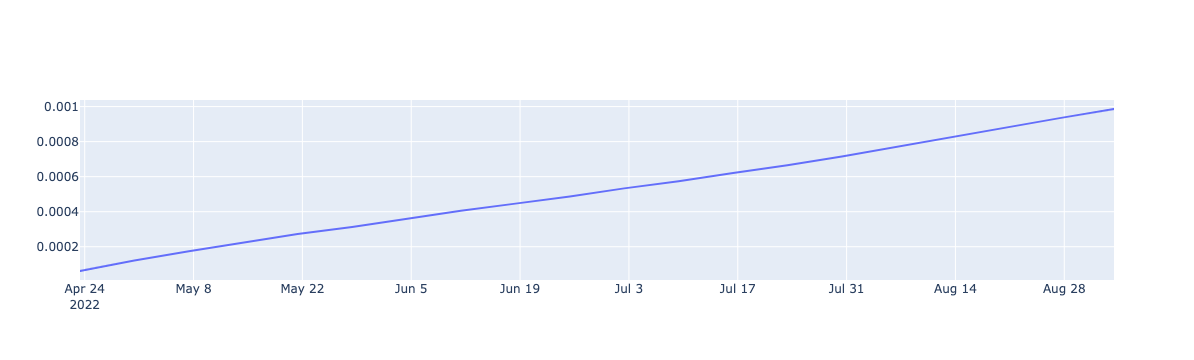

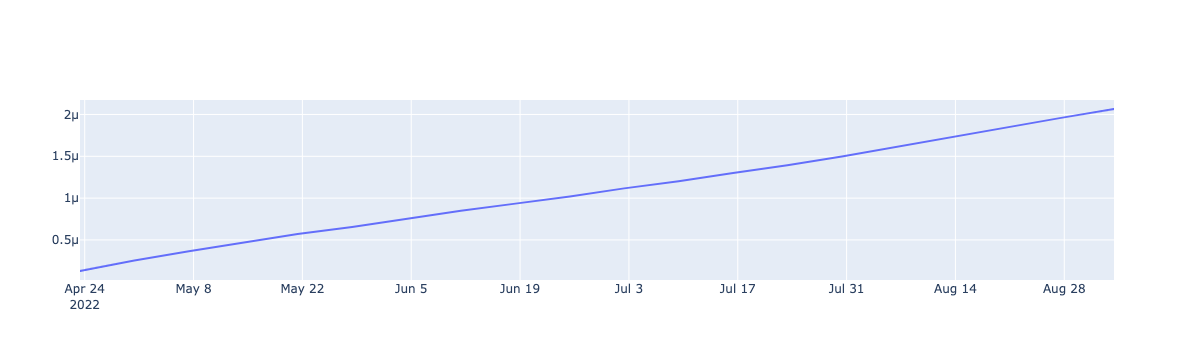

In [76]:
for i in range(-50, 50, 10):
    short_call = get_weekly_short_call(tsla_hourly, i)
    plot_line(short_call, value='running profit', show_afterhours=True)

In [77]:
leap_weekly = get_option_history(aggregate(tsla, freq='weekly'), strike=285, expiration='9/30/2022', risk_free=3)
# PMCC = 

In [79]:
leap_weekly

option value intrinsic value time value     delta  \
2022-04-23 09:30:00    74.806104       50.016633  24.789471  0.750001   
2022-04-30 09:30:00    43.366037        5.253304  38.112733  0.602931   
2022-05-07 09:30:00    41.379069        3.549971  37.829098  0.594742   
2022-05-14 09:30:00    23.633662               0  23.633662  0.450185   
2022-05-21 09:30:00    10.100737               0  10.100737  0.272906   
2022-05-28 09:30:00    20.377963               0  20.377963  0.422538   
2022-06-04 09:30:00    12.574955               0  12.574955   0.32002   
2022-06-11 09:30:00    11.082363               0  11.082363  0.299026   
2022-06-18 09:30:00     6.435196               0   6.435196  0.211482   
2022-06-25 09:30:00    13.738631               0  13.738631  0.351655   
2022-07-02 09:30:00     7.431333               0   7.431333  0.240036   
2022-07-09 09:30:00     13.54708               0   13.54708  0.360539   
2022-07-16 09:30:00     9.090021               0   9.090021  0.284894   
2022-07-23 09:30:00    20.103964               0  20.103964  0.475534   
2022-07-30 09:30:00    32.415691        12.14997  20.265721   0.62709   
2022-08-06 09:30:00    25.498542        3.169971  22.328571  0.570623   
2022-08-13 09:30:00    31.107387        15.02997  16.077417  0.650115   
2022-08-20 09:30:00    27.215617       11.666637   15.54898  0.631236   
2022-08-27 09:30:00    20.169726            3.09  17.079726   0.56528   
2022-09-03 09:30:00     9.554198               0   9.554198  0.385566   

                        gamma     theta      vega       rho  DTE  
2022-04-23 09:30:00  0.002712 -0.131612  0.702651  0.768674  159  
2022-04-30 09:30:00  0.003884 -0.136735  0.722233  0.548185  152  
2022-05-07 09:30:00  0.004022 -0.139548  0.704995  0.517367  145  
2022-05-14 09:30:00  0.004735 -0.127445  0.624364  0.347277  138  
2022-05-21 09:30:00  0.004731 -0.093284  0.440706  0.180505  131  
2022-05-28 09:30:00  0.005004 -0.130568  0.577649  0.294246  124  
2022-06-04 09:30:00  0.005082 -0.112683  0.474835  0.200263  117  
2022-06-11 09:30:00  0.005138 -0.111426  0.442612  0.175881  110  
2022-06-18 09:30:00  0.004742 -0.088972  0.333226    0.1112  103  
2022-06-25 09:30:00  0.005556 -0.135033   0.46754   0.19112   96  
2022-07-02 09:30:00  0.005227 -0.107758  0.348896  0.114895   89  
2022-07-09 09:30:00  0.005942 -0.150094  0.444894  0.172678   82  
2022-07-16 09:30:00  0.005885  -0.13539  0.369385  0.121856   75  
2022-07-23 09:30:00  0.006394 -0.191334  0.467905  0.203734   68  
2022-07-30 09:30:00  0.005879 -0.212409  0.459819  0.257243   61  
2022-08-06 09:30:00  0.006684 -0.225011  0.435243  0.205552   54  
2022-08-13 09:30:00   0.00649 -0.238294  0.398736  0.211109   47  
2022-08-20 09:30:00  0.007246 -0.258547  0.370403  0.175399   40  
2022-08-27 09:30:00  0.008573 -0.285515  0.340943     0.129   33  
2022-09-03 09:30:00  0.010005  -0.28887  0.275789  0.067407   26

In [87]:
PMCC = pd.concat((leap_weekly, short_call), axis='rows')

In [89]:
leap_weekly['date'] = leap_weekly.index
leap_weekly=leap_weekly.reset_index(drop=True)

In [94]:
PMCC = pd.concat((leap_weekly, short_call), axis=1)
PMCC

option value intrinsic value time value     delta     gamma     theta  \
0     74.806104       50.016633  24.789471  0.750001  0.002712 -0.131612   
1     43.366037        5.253304  38.112733  0.602931  0.003884 -0.136735   
2     41.379069        3.549971  37.829098  0.594742  0.004022 -0.139548   
3     23.633662               0  23.633662  0.450185  0.004735 -0.127445   
4     10.100737               0  10.100737  0.272906  0.004731 -0.093284   
5     20.377963               0  20.377963  0.422538  0.005004 -0.130568   
6     12.574955               0  12.574955   0.32002  0.005082 -0.112683   
7     11.082363               0  11.082363  0.299026  0.005138 -0.111426   
8      6.435196               0   6.435196  0.211482  0.004742 -0.088972   
9     13.738631               0  13.738631  0.351655  0.005556 -0.135033   
10     7.431333               0   7.431333  0.240036  0.005227 -0.107758   
11     13.54708               0   13.54708  0.360539  0.005942 -0.150094   
12     9.090021               0   9.090021  0.284894  0.005885  -0.13539   
13    20.103964               0  20.103964  0.475534  0.006394 -0.191334   
14    32.415691        12.14997  20.265721   0.62709  0.005879 -0.212409   
15    25.498542        3.169971  22.328571  0.570623  0.006684 -0.225011   
16    31.107387        15.02997  16.077417  0.650115   0.00649 -0.238294   
17    27.215617       11.666637   15.54898  0.631236  0.007246 -0.258547   
18    20.169726            3.09  17.079726   0.56528  0.008573 -0.285515   
19     9.554198               0   9.554198  0.385566  0.010005  -0.28887   

        vega       rho  DTE                date  underlying open  \
0   0.702651  0.768674  159 2022-04-23 09:30:00       334.219967   
1   0.722233  0.548185  152 2022-04-30 09:30:00       326.463301   
2   0.704995  0.517367  145 2022-05-07 09:30:00       287.209971   
3   0.624364  0.347277  138 2022-05-14 09:30:00       278.803305   
4   0.440706  0.180505  131 2022-05-21 09:30:00       255.999974   
5   0.577649  0.294246  124 2022-05-28 09:30:00       218.333312   
6   0.474835  0.200263  117 2022-06-04 09:30:00       257.869974   
7   0.442612  0.175881  110 2022-06-11 09:30:00       244.666642   
8   0.333226    0.1112  103 2022-06-18 09:30:00       222.999978   
9    0.46754   0.19112   96 2022-06-25 09:30:00       224.459978   
10  0.348896  0.114895   89 2022-07-02 09:30:00       249.369975   
11  0.444894  0.172678   82 2022-07-09 09:30:00       222.709978   
12  0.369385  0.121856   75 2022-07-16 09:30:00       251.853308   
13  0.467905  0.203734   68 2022-07-23 09:30:00       244.999976   
14  0.459819  0.257243   61 2022-07-30 09:30:00       272.206639   
15  0.435243  0.205552   54 2022-08-06 09:30:00       301.333303   
16  0.398736  0.211109   47 2022-08-13 09:30:00       294.833304   
17  0.370403  0.175399   40 2022-08-20 09:30:00       301.773303   
18  0.340943     0.129   33 2022-08-27 09:30:00       292.136637   
19  0.275789  0.067407   26 2022-09-03 09:30:00       283.000000   

    underlying high  underlying low  underlying close      strike  \
0        335.076633      334.219967        335.016633  467.907953   
1        332.996633      278.726639        290.253304  457.048621   
2        317.693302      283.753305        288.549971  402.093960   
3        278.803305      233.699977        256.529974  390.324628   
4        255.999974      213.896645        221.299978  358.399964   
5        252.729975      207.999979        253.209975  305.666636   
6        261.563307      234.449977        234.516643  361.017964   
7        251.343308      229.249977        232.229977  342.533299   
8        232.759977      209.683312        216.759978  312.199969   
9        245.419975      224.459978        245.706642  314.243969   
10       249.369975      221.043311        227.263311  349.117965   
11       254.209975      218.173312        250.763308  311.793969   
12       251.853308      225.613311        240.066643  352.594631   
13       27

In [96]:
PMCC['option value'], PMCC['running profit']

(0     74.806104
 1     43.366037
 2     41.379069
 3     23.633662
 4     10.100737
 5     20.377963
 6     12.574955
 7     11.082363
 8      6.435196
 9     13.738631
 10     7.431333
 11     13.54708
 12     9.090021
 13    20.103964
 14    32.415691
 15    25.498542
 16    31.107387
 17    27.215617
 18    20.169726
 19     9.554198
 Name: option value, dtype: object,
 0     1.286597e-07
 1     2.543333e-07
 2     3.648963e-07
 3     4.722230e-07
 4     5.707715e-07
 5     6.548200e-07
 6     7.540883e-07
 7     8.482740e-07
 8     9.341189e-07
 9     1.020526e-06
 10    1.116522e-06
 11    1.202255e-06
 12    1.299208e-06
 13    1.393522e-06
 14    1.498309e-06
 15    1.614309e-06
 16    1.727806e-06
 17    1.843975e-06
 18    1.956435e-06
 19    2.065377e-06
 Name: running profit, dtype: float64)

In [98]:
short_call = get_weekly_short_call(tsla_hourly, -10)
PMCC = pd.concat((leap_weekly, short_call), axis=1)
PMCC['option value'] + PMCC['running profit']

0     74.488057
1      76.16183
2     73.246161
3     78.173345
4     90.607021
5     66.320248
6     82.239852
7       93.5343
8     95.446479
9     81.824687
10    97.981163
11     76.36251
12    84.052783
13    68.174246
14    55.932456
15    62.610163
16    63.444556
17    65.091607
18    62.510706
19    65.090447
dtype: object